# Ch7. 特征学习：以 AI促 AI 

在探讨特征工程技术的最后一章中，我们研究目前最强大的一种工具。特征学习算法可以接收清洗后的数据（是的，还是需要一部分人力工作），通过数据的潜在结构创建全新的特征。听起来很熟悉？这是因为上一章也是这样定义特征转换的。**这两类算法的差异在于创建新特征时的参数假设**。

本章将包括如下主题：

- 数据的参数假设；
- **受限玻尔兹曼机**（RBM，restrictedBoltzmannmachine）；
- **伯努利受限玻尔兹曼机**（BernoulliRBM）；
- 从MNIST中提取RBM特征；
- 在机器学习流水线中应用RBM；
- 学习文本特征——词向量。

## 7.1 数据的参数假设 

**参数假设是指算法对数据形状的基本假设**。在上一章中当探索主成分分析（PCA）时，我们发现可以利用算法的结果产生主成分，通过矩阵乘法来转换数据。**我们的假设是，原始数据的形状可以进行（特征值）分解，并且可以用单个线性变换（矩阵计算）表示**。但如果不是这样呢？如果PCA不能从原始数据集中提取有用的特征，那该怎么办呢？PCA和线性判别分析（LDA）这样的算法肯定能找到特征，但找到的特征不一定有用。此外，这些算法都基于预定的算式，每次肯定输出同样的特征。这也是我们将PCA和LDA都视为线性变换的原因。

**特征学习算法希望可以去除这个参数假设，从而解决该问题**。这些算法不会对输入数据的形状有任何假设，而是依赖于随机学习（stochasticlearning）。意思是，这些算法并不是每次输出相同的结果，而是一次次按轮（epoch）检查数据点以找到要提取的最佳特征，并且拟合到一个解决方案（在运行时可能会有所不同）。

这样，特征学习算法可以绕过PCA和LDA等算法的参数假设，解决比之前更难的问题。这种复杂的想法（绕过参数假设）需要使用复杂的算法。很多数据科学家和机器学习流水线会使用深度学习算法，从原始数据中学习新特征。

我们假设读者已经对神经网络架构有基本的了解，以便专注地利用这些架构进行特征学习。下表总结了特征学习和特征转换的基本区别。

|              | 需要参数 | 使用简单 | 创建新特征 | 深度学习 |
| ------------ | -------- | -------- | ---------- | -------- |
| 特征转换算法 | 是       | 是       | 是         | 否       |
| 特征学习算法 | 否       | 一般否   | 是         | 一般是   |


事实上，特征学习和特征转换算法都创造了新的特征集，意思是我们认为这两类算法都属于**特征提取**。

### 7.1.1 非参数谬误 

需要注意的是，非参数模型不代表模型在训练中对数据完全没有假设。

虽然本章介绍的算法不需要对数据形状做出假设，但是依然可以对数据的其他方面进行假设，例如单元格的值等。

### 7.1.2 本章的算法 

本章中我们重点关注以下两个特征学习领域。

- **受限玻尔兹曼机**（RBM）：一种简单的深度学习架构，根据数据的概率模型学习一定数量的新特征。这些机器其实是一系列算法，但scikit-learn中只实现了一种。BernoulliRBM可以作为非参数特征学习器，但是顾名思义，这个算法对单元格有一些假设。

- **词嵌入**：可以说是深度学习在自然语言处理/理解/生成领域最近进展的主要推动者之一。词嵌入可以将字符串（单词或短语）投影到n维特征集中，以便理解上下文和措辞的细节。我们用Python的gensim包准备词嵌入，然后借助预训练过的词嵌入来研究它能如何增强我们与文本的交互能力。

这些例子有一些共同点：都涉及从原始数据中学习新特征，然后利用这些新特征加强与数据交互的方式。对于后两个例子，我们需要放弃scikit-learn，因为这些高级技术在scikit-learn中尚未提供。

对于所有的技术，我们都不会太关注低层的原理，而是更关注这些算法如何解释数据。我们按顺序开始介绍，首先是唯一有scikit-learn实现的算法——受限玻尔兹曼机系列。

## 7.2 受限玻尔兹曼机 

RBM是一组无监督的特征学习算法，使用概率模型学习新特征。与PCA和LDA一样，我们可以使用RBM从原始数据中提取新的特征集，用于增强机器学习流水线。**在RBM提取特征之后使用线性模型（线性回归、逻辑回归、感知机等）往往效果最佳**。

RBM的无监督性质很重要，所以它和PCA的相似性高于和LDA的相似性。RBM和PCA算法在提取新特征时都不需要真实值，可以用于更多的机器学习问题。

在概念上说，RBM是一个浅层（两层）的神经网络，属于**深度信念网络**（DBN，deepbeliefnetwork）算法的一种。用标准的术语讲，这个网络有一个可见层（第一层），后面是一个隐藏层（第二层）。下图展示了网络中仅有的两层。

![ddd](featureCh6_files/boerziman.png)

和其他的神经网络一样，这两层中都有节点。网络可见层的节点数和输入数据的特征维数相同。在下面的例子中，我们的图像是28×28的，也就是说输入层有784个节点。隐藏层的节点数是人为选取的，代表我们想学习的特征数。

### 7.2.1 不一定降维 

PCA和LDA对可以提取的特征数量有严格的限制。对于PCA，我们受限于原始特征的数量（只能使用等于或小于原始特征数的输出），而LDA的要求更加严格，只能输出类别的数量减1。


RBM可以学习的特征数量只受限于计算机的计算能力，以及人为的解释。**RBM可以学习到比初始输入更少或更多的特征。具体要学习的特征数量取决于要解决的问题，可以进行网格搜索。**

### 7.2.2 受限玻尔兹曼机的图

目前，我们已经看到了RBM的可见层和隐藏层，但是还不清楚RBM如何学习特征。每个可见层的节点从要学习的数据集中取一个特征。然后，数据通过权重和偏差，从可见层传递到隐藏层：

![ddd](featureCh6_files/boerziman2.png)

对RBM的可视化显示了单个数据点如何通过图——通过单个隐藏节点。可见层有4个节点，代表原始数据的4列。每个箭头代表数据点的一个特征，从RBM第一层的4个可见节点中穿过。然后，每个特征和相关的权重相乘，并求和。该计算也可以用数据的输入向量和权重向量的点积表示。最终的加权结果会加上一个偏差变量，并通过激活函数（一般使用S形函数）。结果储存在名称为a的变量中。

下面的Python代码显示了单个数据点（inputs）如何与权重向量相乘并与偏差向量结合，以创建激活变量a：

In [1]:
import numpy as np
import math

# S 形函数
def activation(x):
    return 1 / (1 + math.exp(-x))

inputs = np.array([1, 2, 3, 4])
weights = np.array([0.2, 0.324, 0.1, .001])
bias = 1.5

a = activation(np.dot(inputs.T, weights) + bias)
print(a)

0.9341341524806636


在真实的 RBM中，每个可见节点都和所有的隐藏节点相连接，如下图所示。 

![ddd](featureCh6_files/boerziman3.png)

### 7.2.3 玻尔兹曼机的限制 

通过上图，我们看见了层与层之间的连接（层间连接），但是没有看见同一层内节点的连接（层内连接）。这是因为没有这种连接。**RBM的限制是，不允许任何层内通信**。这样，节点可以独立地创造权重和偏差，最终成为（希望是）独立的特征。

### 7.2.4 数据重建 

在网络的前向传导中，我们看见数据可以向前通过网络（从可见层到隐藏层），但是这并不能解释为什么RBM可以不依赖真实值而学习新特征。RBM的学习来自于可见层和隐藏层间的多重前后向传导。

在重建阶段，我们调转网络，把隐藏层变成输入层，用相同的权重将激活变量（a）反向传递到可见层，但是偏差不同。然后，用前向传导的激活变量重建原始输入向量。下图显示了如何使用相同的权重和不同的偏差，通过网络进行反向激活。

![ddd](featureCh6_files/boerziman4.png)

RBM用这种方式进行自我评估。通过将激活信息进行后向传导并获取原始输入的近似值，该网络可以调整权重，让近似值更接近原始输入。在训练开始时，由于权重是随机初始化的（标准做法），近似值有可能相差很大。然后，通过反向传播（和前向传导的方向相同，的确很绕）调整权重，最小化原始输入和近似值的距离。我们重复这个过程，直到近似值尽可能接近原始的输入。这个过程发生的次数叫作迭代次数。

这个过程的最终结果是一个网络，其中有每个数据点的第二自我。要转换数据，我们只需要将数据传入该网络，并计算激活变量，输出结果就是新的特征。这个过程是一种生成性学习，试图学习一种可以生成原始数据的概率分布，并且利用知识来提取原始数据的新特征集。

例如，给定一个数字（0～9）的图片，并要求按数字进行分类。这个网络的前向传导会问：给定这些像素，应该是什么数字？后向传导时，网络会问：给定一个数字，应该出现哪些像素？这称为联合概率，即“给定x时有y”和“给定y时有x”共同发生的概率，也是网络两个层的共享权重。

下面介绍一下新的数据集，它会展示 RBM在特征学习中的作用。 

### 7.2.5 MNIST数据集 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, datasets, metrics
# scikit-learn 的 RBM
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

images = np.genfromtxt('C:/pwork/Feature-Engineering-Made-Easy/data/mnist_train.csv', delimiter=',')
images.shape

(6000, 785)

In [3]:
# 提取 X 和 y 变量 
images_X, images_y = images[:,1:], images[:,0] 

In [4]:
# 值很大，但是 scikit-learn 的 RBM 会进行 0～1 的缩放
np.min(images_X), np.max(images_X)

(0.0, 255.0)

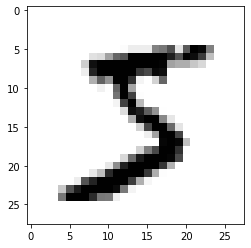

In [5]:
plt.imshow(images_X[0].reshape(28, 28), cmap=plt.cm.gray_r)

## 7.3 伯努利受限玻尔兹曼机 

scikit-learn中唯一的RBM实现是BernoulliRBM，因为它对原始数据的范围进行了约束。伯努利分布要求数据的值为0～1。scikit-learn的文档称，该模型假定输入是二进制的值，或者是0~1的数。这个限制是为了表示节点的值就是节点被激活的概率，从而可以更快地学习特征集。为了进行解释，我们修改一下原始数据集，只考虑硬编码的黑白像素强度。这样，每个像素的值会变成0或1（白或黑），让学习更加稳健。我们分两步完成：

(1) 将像素的值缩放到 0～1； 

(2) 如果超过0.5，将值变成真，否则为假。 

In [6]:
# 把 images_X 缩放到 0~1 
images_X = images_X / 255.

# 二分像素（白或黑）
images_X = (images_X > 0.5).astype(float)
np.min(images_X), np.max(images_X)

(0.0, 1.0)

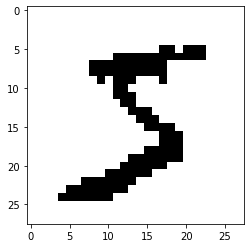

In [7]:
plt.imshow(images_X[0].reshape(28, 28), cmap=plt.cm.gray_r)

### 7.3.1 从MNIST中提取 PCA主成分 

Text(0.5, 0.98, '100 components extracted by PCA')

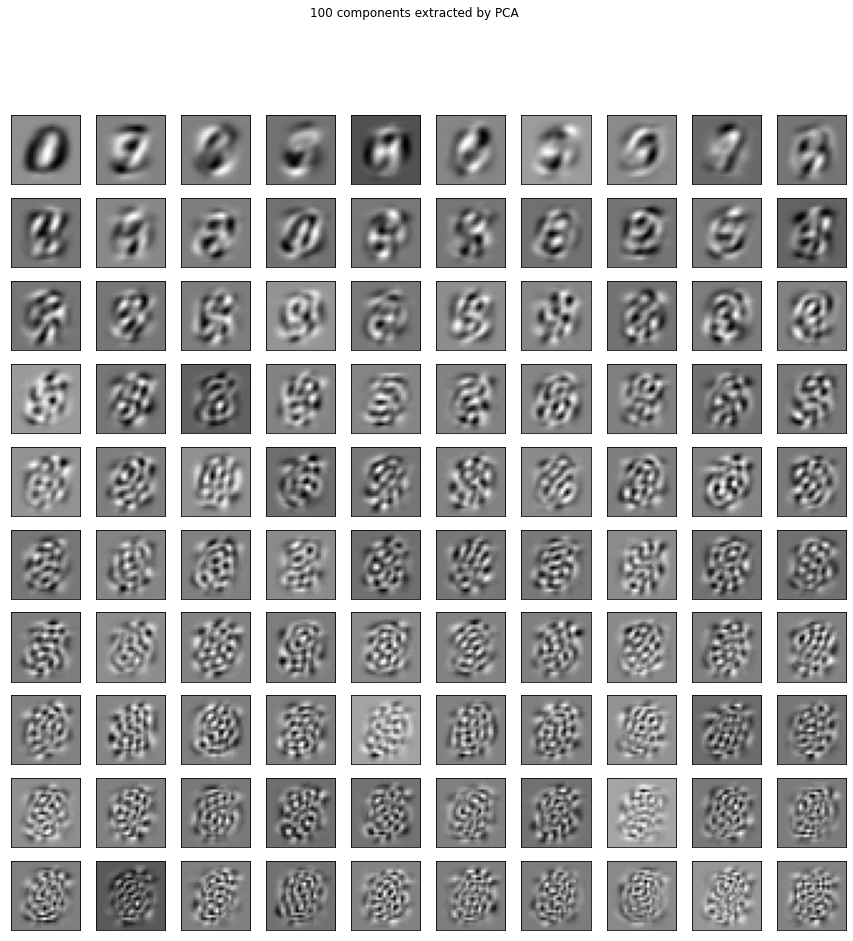

In [8]:
from sklearn.decomposition import PCA

# 100 个特征数字 
pca = PCA(n_components=100)
pca.fit(images_X)

# 绘制 100 个主成分
plt.figure(figsize=(15, 15))
for i, comp in enumerate(pca.components_):
    plt.subplot(10, 10, i+1)
    plt.imshow(comp.reshape(28, 28), cmap=plt.cm.gray_r)
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by PCA')

In [9]:
pca.explained_variance_ratio_[:30].sum()

0.6374141396828567

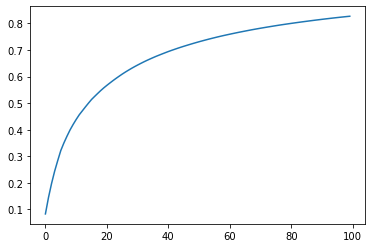

In [10]:
# 碎石图
# 所有的特征数字
full_pca = PCA(n_components=784)
full_pca.fit(images_X)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [11]:
# 两种方法其实不一样
images_X[0].shape, images_X[:1].shape

((784,), (1, 784))

In [12]:
# 用拟合过的 PCA 对象对第一个图像进行转换，提取 100 个新特征
print(pca.transform(images_X[:1]))

# 然后是矩阵乘法 
np.dot(images_X[:1]-images_X.mean(axis=0), pca.components_.T)

[[ 0.61090568  1.36377972  0.42170385 -2.19662828 -0.45181075 -1.32049501
   0.79434683  0.30551122  1.2297898  -0.72096755  0.08168363 -1.91375449
  -2.54647194 -1.62440704  0.67106987  0.15635689  0.91831099 -0.189816
   1.30140739  1.5793181   0.99053179  0.11280898  1.07343799  0.70135987
  -0.35906843  0.16664712  0.99301697 -0.731206    0.8697016  -0.18638702
  -0.72501847  0.11274416  0.16109092  0.0733832   0.11752455 -0.73016445
  -0.29719858  0.17426955  0.29967903  2.32419836 -0.20448857 -0.85508365
   0.67769317  0.34843818  0.33965514 -0.42077229 -0.2098547   0.39443919
  -0.31189304  0.38597346  0.06392608  0.07527956  0.63569327  0.80027357
  -0.40605698  0.02379926 -0.17840382  0.15255155 -0.53473423 -0.35286039
  -0.40821359 -0.49890817  0.4731743   0.31335881  0.45437144  0.63826445
  -0.71330422  0.44896671 -0.23015852 -0.02080067  0.19476371  0.64473734
   0.28038114  0.55740402 -0.27417881 -0.30238939  0.72771994 -0.08439949
   0.71695036 -0.00319249  0.25336786  0

array([[ 0.61090568,  1.36377972,  0.42170385, -2.19662828, -0.45181075,
        -1.32049501,  0.79434683,  0.30551122,  1.2297898 , -0.72096755,
         0.08168363, -1.91375449, -2.54647194, -1.62440704,  0.67106987,
         0.15635689,  0.91831099, -0.189816  ,  1.30140739,  1.5793181 ,
         0.99053179,  0.11280898,  1.07343799,  0.70135987, -0.35906843,
         0.16664712,  0.99301697, -0.731206  ,  0.8697016 , -0.18638702,
        -0.72501847,  0.11274416,  0.16109092,  0.0733832 ,  0.11752455,
        -0.73016445, -0.29719858,  0.17426955,  0.29967903,  2.32419836,
        -0.20448857, -0.85508365,  0.67769317,  0.34843818,  0.33965514,
        -0.42077229, -0.2098547 ,  0.39443919, -0.31189304,  0.38597346,
         0.06392608,  0.07527956,  0.63569327,  0.80027357, -0.40605698,
         0.02379926, -0.17840382,  0.15255155, -0.53473423, -0.35286039,
        -0.40821359, -0.49890817,  0.4731743 ,  0.31335881,  0.45437144,
         0.63826445, -0.71330422,  0.44896671, -0.2

### 7.3.2 从MNIST中提取 RBM特征 

现在在scikit-learn中创建第一个RBM对象。我们先实例化一个模块，从MNIST数据集中提取100个特征。

我们将verbose参数设置为True，以查看训练过程，并且将random_state设置为0。参数random_state是一个整数，可以复现训练结果。它会固定随机数生成器，每次都同时随机设置权重和偏差。最后将迭代次数n_iter设置为20，也就是我们希望网络进行的前后向传导次数：

In [13]:
# 实例化 BernoulliRBM 
# 设置 random_state，初始化权重和偏差 
# verbose 是 True，观看训练 
# n_iter 是前后向传导次数 
# n_components 与 PCA 和 LDA 一样，代表我们希望创建的特征数 
# n_components 可以是任意整数，小于、等于或大于原始特征数均可 

rbm = BernoulliRBM(random_state=0, verbose=True, n_iter=20, n_components=100)
rbm.fit(images_X)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -138.59, time = 3.55s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -120.25, time = 4.19s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -125.61, time = 4.47s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -120.42, time = 4.98s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -110.73, time = 5.06s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -119.44, time = 4.50s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -108.65, time = 4.79s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -119.18, time = 4.97s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -106.43, time = 5.28s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -111.75, time = 4.81s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -108.04, time = 5.24s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -111.99, time = 5.62s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -122.52, time = 4.91s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -109.20, time = 4.64s
[BernoulliRBM] 

BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=100, n_iter=20,
             random_state=0, verbose=True)

In [14]:
# RBM 也有 components_ 
len(rbm.components_) 

100

也可以对RBM特征进行可视化，查看它和特征数字的区别：

Text(0.5, 0.98, '100 components extracted by RBM')

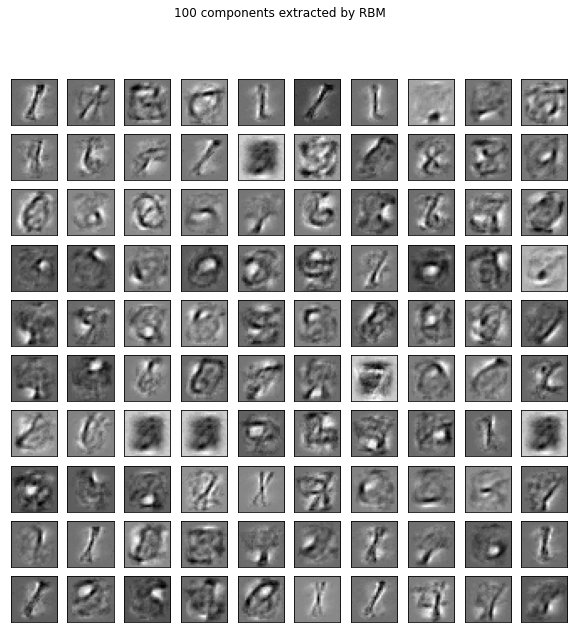

In [15]:
# 绘制 RBM 特征（新特征集的表示）
plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i+1)
    plt.imshow(comp.reshape(28, 28), cmap=plt.cm.gray_r)
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM')

In [16]:
# 好像有些特征一样 
# 但是其实所有的特征都不一样（虽然有的很类似）
np.unique(rbm.components_.mean(axis=1)).shape

(100,)

In [17]:
# 用玻尔兹曼机转换数字 5 

image_new_features = rbm.transform(images_X[:1]).reshape(100,)
image_new_features

array([4.08618027e-17, 1.66637099e-11, 4.14094395e-13, 1.70581384e-08,
       4.15517284e-19, 1.93337000e-14, 2.72726121e-21, 1.83394462e-07,
       2.57596676e-24, 1.39093385e-07, 1.14599310e-11, 3.40159615e-04,
       1.51823756e-24, 6.19003415e-15, 1.00000000e+00, 9.99999986e-01,
       4.95266421e-17, 1.39393738e-09, 2.05250737e-02, 1.25938189e-07,
       1.92941164e-08, 1.00000000e+00, 5.62929546e-14, 7.65548909e-05,
       4.06679965e-16, 1.07994397e-14, 1.28483049e-01, 1.46326907e-06,
       9.99999803e-01, 9.99999999e-01, 3.41067924e-03, 4.76559960e-09,
       1.58541353e-13, 1.08176109e-06, 1.00000000e+00, 7.27205985e-20,
       2.02991256e-12, 8.61266617e-11, 8.13866405e-01, 1.80769336e-13,
       2.90099526e-15, 9.24188353e-01, 4.19320292e-10, 3.10714788e-09,
       5.88456350e-09, 9.99319729e-01, 5.58121562e-09, 2.86888672e-11,
       9.88374580e-04, 1.00000000e+00, 2.10903992e-24, 1.95632662e-23,
       1.35458185e-15, 2.58515822e-11, 8.12769366e-18, 1.12708083e-08,
      

In [18]:
# 不是简单的矩阵乘法了 
# 使用神经网络架构（几个矩阵操作）来转换特征 
np.dot(images_X[:1]-images_X.mean(axis=0), rbm.components_.T)

array([[ -3.87847833,  -6.5082649 , -16.21224287,   4.02851745,
         -8.28869893,  -1.6355449 ,  -8.08121004, -25.04963673,
        -32.93824982,  -6.35346779,   1.72980495,  20.44404666,
        -27.82627305,  -3.92397174,   9.15472274,  27.91756959,
        -10.33459741,  -0.1900554 ,  15.37098979,  -6.41872884,
         -4.60023162,  35.07136163, -15.52020191,   5.4507319 ,
         -6.17694318,  -5.99131489,   9.52098189,  14.6256272 ,
         29.43561442,  17.69358081,  10.50126376,  -6.7540146 ,
        -20.69692959,  16.8554903 ,  40.04073451, -24.89675349,
         -4.30746752,  17.19875436,   0.72278895, -43.71302383,
        -25.74680268,  20.05072435,  -3.61917686,  -8.85815697,
         -1.06310196,  19.90097699,  -0.80398435,  -8.48982006,
         -0.9817437 ,  33.64282798, -30.40100379, -25.00731843,
         -6.67861532, -11.01909339, -10.24586622,   5.30449734,
          9.76499446,  -9.56496463,   2.11289134,  15.87866396,
        -12.18124087,  -1.14321828,   8.

现在我们有 100个新特征，而且进行了观察。下面就在数据上应用特征。 

从第一个图像（数字 5）中提取 20个最有代表性的特征： 

In [19]:
# 最有代表性的特征 
top_features = image_new_features.argsort()[-20:][::-1]
print(top_features)
image_new_features[top_features]


[14 56 62 63 69 82 21 34 49 92 29 15 28 83 45 77 41 38 94 26]


array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999999, 0.9999998 , 0.99998581, 0.99931973,
       0.99828441, 0.92418835, 0.81386641, 0.24985129, 0.12848305])

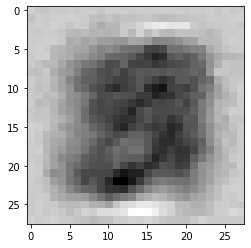

In [20]:
top_features[0]
plt.imshow(rbm.components_[14].reshape(28, 28), cmap=plt.cm.gray_r)

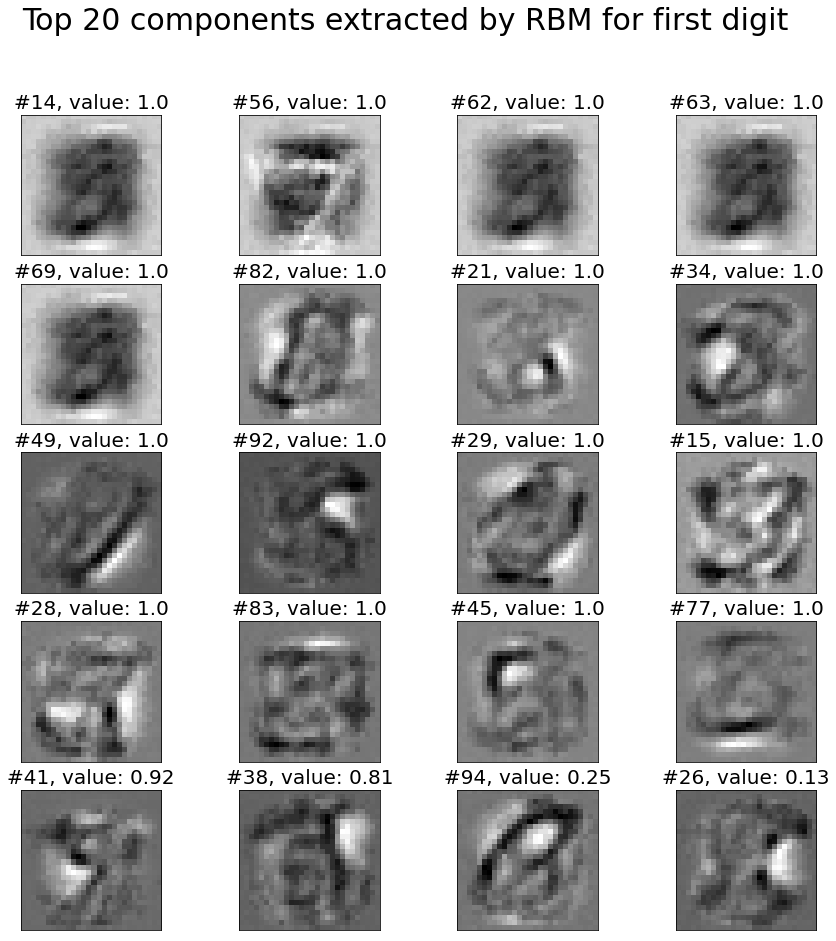

In [21]:
plt.figure(figsize=(15, 15))
for i, comp in enumerate(top_features):
    plt.subplot(5, 4, i+1)
    plt.imshow(rbm.components_[comp].reshape(28, 28), cmap=plt.cm.gray_r)
    plt.title("#{}, value: {}".format(comp, round(image_new_features[comp], 2)), fontsize=20)
    plt.suptitle('Top 20 components extracted by RBM for first digit', fontsize=30)
    plt.xticks(())
    plt.yticks(())

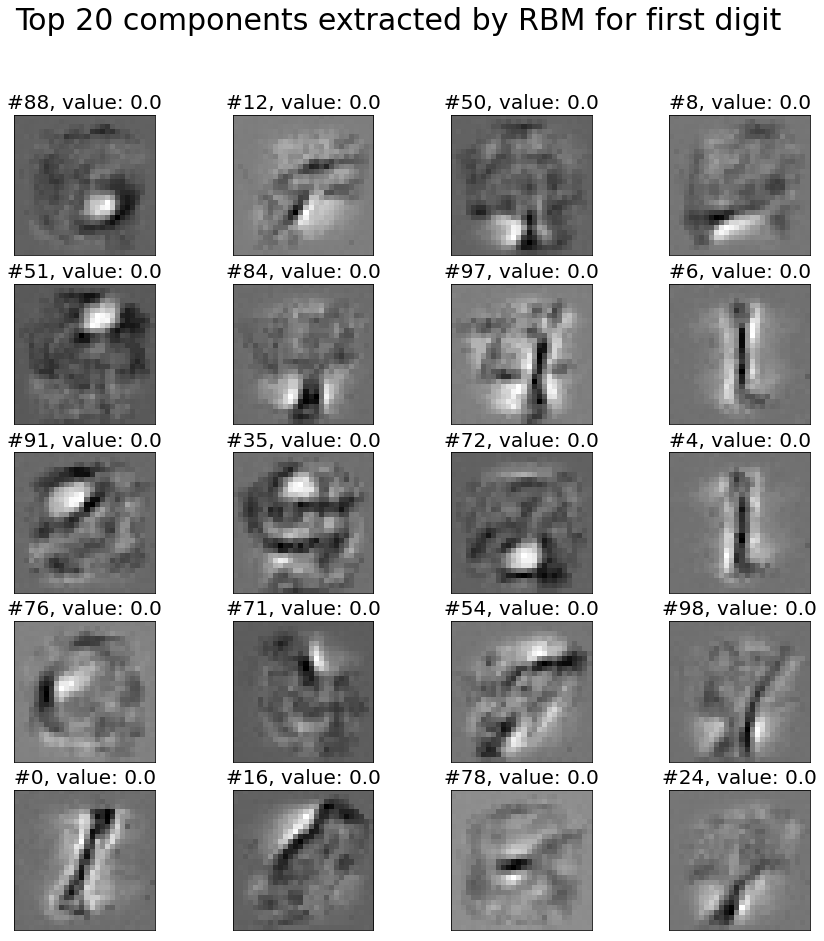

In [22]:
# 最差的特征 
bottom_features = image_new_features.argsort()[:20]

plt.figure(figsize=(15, 15))
for i, comp in enumerate(bottom_features):
    plt.subplot(5, 4, i+1)
    plt.imshow(rbm.components_[comp].reshape(28, 28), cmap=plt.cm.gray_r)
    plt.title("#{}, value: {}".format(comp, round(image_new_features[comp], 2)), fontsize=20)
    plt.suptitle('Top 20 components extracted by RBM for first digit', fontsize=30)
    plt.xticks(())
    plt.yticks(())

## 7.4 在机器学习流水线中应用 RBM 

当然了，我们不仅希望可视化RBM，并且希望在机器学习流水线中应用它，还希望看见特征学习的具体结果。因此，要创建并运行三条流水线：

- 原始像素强度上的逻辑回归模型；
- PCA主成分上的逻辑回归；
- RBM特征上的逻辑回归。

每条流水线都会对（PCA和 RBM的）多个特征和参数 C 进行网格搜索，以进行逻辑回归。我们从最简单的流水线入手，在原始数据上运行逻辑回归，看看线性模型能否区分数字。 

In [23]:
np.unique(images_y)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

### 7.4.1 对原始像素值应用线性模型 

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(max_iter=10000) #  为了避免ConvergenceWarning出现，更改max_iter默认的1000改为10000
params = {
    'C': [1e-2, 1e-1, 1e0, 1e1, 1e2],
}

grid = GridSearchCV(lr, params)

grid.fit(images_X, images_y)
print(grid.best_params_, grid.best_score_)

{'C': 0.1} 0.898


逻辑回归本身的效果就很好，用原始数据就达到了 89.08%的交叉验证准确率。 

### 7.4.2 对提取的 PCA主成分应用线性模型 

我们看看加入PCA后能不能提高准确率。首先设置变量。这次需要创建一个scikit-learn流水线对象，用于容纳PCA模块和线性模型。保持线性分类器的参数不变，寻找PCA的新参数，看看10、100和200个主成分哪个最好。试着花时间猜一下结果（提示：想想碎石图中的方差）：


In [25]:
# 用 PCA 提取特征
lr = LogisticRegression(max_iter=10000)
pca = PCA()

# 设置流水线的参数
params = {
    'clf__C': [1e-1, 1e0, 1e1],
    'pca__n_components': [10, 100, 200]
}

# 创建流水线 
pipeline = Pipeline([
    ('pca', pca), ('clf', lr)
])
grid = GridSearchCV(pipeline, params)

grid.fit(images_X, images_y)
print(grid.best_params_, grid.best_score_)

{'clf__C': 0.1, 'pca__n_components': 200} 0.9003333333333334


结果是88.77%的交叉验证准确率，稍差一点。如果进行了思考，那么100比10和200表现更好并不令人惊讶。在上一节的碎石图中，30个主成分解释了64%的变化，所以10个主成分肯定不足以解释图像。在100个主成分后，碎石图开始变平，代表在第100个主成分后，解释的方差没有增加太多。因此200个主成分太多了，会导致过拟合。综上所述，100个PCA主成分是最佳数量。需要注意，我们可以进一步尝试调整超参，寻找更好的PCA主成分数量。不过目前到此为止，接下来使用RBM特征。

### 7.4.3 对提取的 RBM特征应用线性模型 

In [26]:
# 用 RBM 学习新特征 
lr = LogisticRegression(max_iter=10000)
rbm = BernoulliRBM()

params = {
    'clf__C':[1e-1, 1e0, 1e1], 
    'rbm__n_components': [100, 200],
}
# 创建流水线 
pipeline = Pipeline([('rbm', rbm), ('clf', lr)])
# 实例化网格搜索类
grid = GridSearchCV(pipeline, params)

grid.fit(images_X, images_y)
print(grid.best_params_, grid.best_score_)

{'clf__C': 1.0, 'rbm__n_components': 200} 0.9265000000000001


RBM模块的交叉验证准确率是92.65%，能从数字中提取200个新特征。除了引入BernoulliRBM模块外，不进行任何操作就可以增加近2.5%的准确率。（很多了！）

## 7.5 学习文本特征：词向量 

解决图像问题后，第二个特征学习的例子是文本和自然语言处理。当机器学习读写时，会遇到一个很大的问题，那就是上下文的处理。在前面的章节中，我们可以计算每个文档中单词出现的次数，从而对文档进行向量化处理，并将向量输入机器学习流水线中。通过构建基于数量计算的特征，我们可以在有监督的机器学习流水线中使用文本。这个办法比较有效，但是有一个问题。我们仅仅是按词袋（BOW，bagofwords）理解文本。这意味着我们只是把文档看作一组无序的单词。


更重要的是，每个单词自身都没有意义。在使用CountVectorizer和TfidfVectorizer时，文档只是单词的集合而已。因此，我们将注意力从scikit-learn转移到一个叫gensim的包上，计算词嵌入。

### 7.5.1 词嵌入 

词嵌入是帮助机器理解上下文的一种方法。词嵌入是单词在n维特征空间中的向量化，其中n代表单词潜在特征的数量。意思是，词汇表中的每个单词不只是字符串，也是向量。例如，我们提取每个单词的n=5个特征，那么词汇表中的每个单词都会变成1×5的向量。向量化的结果有可能是这样的：

In [27]:
# 词嵌入的例子 
king = np.array([.2, -.5, .7, .2, -.9]) 
man = np.array([-.5, .2, -.2, .3, 0.]) 
woman = np.array([.7, -.3, .3, .6, .1]) 
queen = np.array([ 1.4, -1. , 1.2, 0.5, -0.8]) 

向量化后，我们就可以解决这样的问题：对于一个国王，如果将性别从男改为女，会得到什 么？操作如下： 

$$
国王 = 男 + 女 
$$

In [28]:
np.array_equal((king - man + woman), queen)

True

看起来很简单，但是有几个注意事项： 

- 上下文（形式为词嵌入）随语料库的变化而不同，单词的含义也是一样，所以静态的词嵌入不一定是最有用的； 
- 词嵌入依赖于要学习的语料库。

通过词嵌入，我们可以对单个单词进行很精确的计算，以实现在上下文中的理解。

### 7.5.2 两种词嵌入方法：Word2vec和 GloVe 

词嵌入主要有两种算法，分别是Word2vec和GloVe。二者都通过学习大型语料库（文本文档的集合）来产生词嵌入，主要的区别在于（出自斯坦福大学的）GloVe算法通过一系列矩阵统计进行学习，而（出自Google的）Word2vec通过深度学习进行学习。这两种方法各有优缺点，本书主要使用Word2vec算法学习词嵌入。

### 7.5.3 Word2vec：另一个浅层神经网络

为了学习和提取词嵌入，Word2vec会实现另一个浅层神经网络。这次我们不是一股脑地将数据输入可见层，而是故意输入正确的数据，以提供正确的词嵌入。大致来讲，可以想象该神经网络具有下图所示的架构。

![ddd](featureCh6_files/boerziman5.png)

和RBM一样，我们有一个可见的输入层和一个隐藏层。输入层和希望学习的词汇长度相同。如果语料库有几百万词，但是我们只需要学习其中一小部分，那么这种设定很有用。在上图中，我们希望学习5000个单词的上下文。图中的隐藏层代表对于每个单词要学习的特征数。本例要将词嵌入300维的空间中。

这个神经网络和之前RBM神经网络的主要区别在于存在输出层。注意，图中输出层和输入层的节点数量一样。这不是巧合。词嵌入模型通过参考词的存在与否，预测相邻的单词。例如，如果要预测“微积分”一词，那么我们希望math节点点亮最多。这基本上是监督学习算法的大致想法。

然后，我们在这个结构上训练，通过传入单词的独热向量，提取隐藏层的输出向量并将其作为潜在结构，最终学习300维的单词表示。在生产中，因为输出节点非常多，所以上图结构的效率极低。为了加速运算，我们使用不同的损失函数来利用文本的结构特征。

### 7.5.4 创建Word2vec词嵌入的 gensim 包 

In [51]:
import gensim

In [52]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [54]:
from gensim.models import word2vec

sentences = word2vec.Text8Corpus('C:/pwork/Feature-Engineering-Made-Easy/data/text8')

In [60]:
from gensim.models.word2vec import Word2Vec
# 实例化 gensim 模块 
# min-count 忽略出现次数小于该值的单词 
# size 是要学习的单词维数
# model = Word2Vec(sentences, min_count=1, size=20)

学习好了。如果语料库很大，有可能会需要很长时间。现在gensim的拟合已经完成，可供使用。我们可以将单个单词传入word2vec对象，查看词嵌入：

In [ ]:
# 单个单词的嵌入
model.wv['king'] 

In [ ]:
# 女 + 国王 - 男 = 女王 
model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)

不太好，没有得到期望的 queen。我们试试关于巴黎的问题： 

In [ ]:
# 伦敦之于英国相当于巴黎之于？ 
model.wv.most_similar(positive=['Paris', 'England'], negative=['London'], topn=1)

### 7.5.5 词嵌入的应用：信息检索 

## 7.6 小结

本章重点介绍了两种特征学习工具：RBM和词嵌入。

这两种工具都使用深度学习架构从原始数据中学习新的特征集。两种技术都用较浅的网络来优化训练时间，并且用拟合阶段学到的权重和偏差来提取数据的潜在结构。

下一章包含两个特征工程的例子，全部基于从互联网上收集的真实数据，并且会展示如何使用从本书学到的工具来创建最佳的机器学习流水线。